## Agreement between readers

Following: 
Ranganathan, P., Pramesh, C. S., & Aggarwal, R. (2017). Common pitfalls in statistical analysis: Measures of agreement. Perspectives in clinical research, 8(4), 187–191. https://doi.org/10.4103/picr.PICR_123_17
https://doi.org/10.4103%2Fpicr.PICR_123_17

For metric variables ->  ICC

For ordinal -> Cohen's Kappa weighted version 

For categorical -> Cohen's Kappa not weighted version 



In [1]:
import os
import sys
import pandas as pd
pd.options.mode.copy_on_write = True 

from pathlib import Path
import cdata_utils
import numpy as np
import cdata_utils.utils
import datetime

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy
import scipy.stats

rng = np.random.default_rng(seed=2024)

import json

#import cdata_utils.preprocess.read_and_clean_tabular
from cdata_utils.project_specific.psvd import (
    read_and_clean_PSVD_data__BL_consensus,
    categorize_PSVD_data,
    exclude_patients,
    reorder_some_categorical_values, 
    table1_psvd, 
    table1_psvd_spleen, 
    descriptive_df_from_masks, 
    masks_for_endpoint_1__decompensation, 
    masks_for_endpoint_2__death,
    make_y_delta,
    drop_non_numeric_columns,
    table_of_valid_entries, 
    univariate_cox_ph_summary, 
    normalize_df,
    columns_important_variables_BL_FU,
    categorize_PSVD_data_, 
    flatten, 
    read_and_clean_PSVD_data__BL_FU_consensus,
)

from cdata_utils.descriptive.basic_stats import (
    describe, 
    convert_bool_bool_to_int,
)

import cdata_utils.preprocess
import cdata_utils.project_specific
import cdata_utils.project_specific.psvd


import lifelines
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

from sklearn.preprocessing import StandardScaler

# path info: 
if "cwatzenboeck" in os.getcwd(): # desktop 
    data_path = Path("/home/cwatzenboeck/Dropbox/work/data/livermodel/PSVD/")
    data_path_output=Path("/home/cwatzenboeck/data/psvd/output_coxph/")
else: # laptop 
    data_path = Path("/home/clemens/Dropbox/work/data/livermodel/PSVD/")
    # data_path = Path("/home/clemens/projects/project_liver_model/data/PSVD")
    
import sklearn
import sklearn.metrics    
from sklearn.metrics import cohen_kappa_score


import pingouin as pg

In [2]:
# CODE

from cdata_utils.project_specific.psvd import (
    rename_columns_by_prefix,
    read_renaming_dict
)


def read_and_clean_PSVD_data__BL_FU_consensus(data_path: Path | str, 
                                           verbose=False, 
                                           file_name = "data_PSVD_unified_1.xlsx" #"data_PSVD_orig.xlsx"
                                           ):
    data_origin_path = data_path / file_name
    dfo = pd.read_excel(data_origin_path)
    df = dfo.copy()
    df = df.drop(columns=["Name", "Prename", "DOB"])

    # rename inconsistent column names: 
    df = rename_columns_by_prefix(df, prefix_old="BL_1 ", prefix_new="BL1 ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="BL_2 ", prefix_new="BL2 ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="BL_1", prefix_new="BL1", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="BL 1_", prefix_new="BL1 ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="BL_2", prefix_new="BL2", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="BL_", prefix_new="BL ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="BL-", prefix_new="BL ", verbose=verbose)

    df = rename_columns_by_prefix(df, prefix_old="FU_1 ", prefix_new="FU1 ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="FU_2 ", prefix_new="FU2 ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="FU_1", prefix_new="FU1", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="FU 1_", prefix_new="FU1 ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="FU_2", prefix_new="FU2", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="FU_", prefix_new="FU ", verbose=verbose)
    df = rename_columns_by_prefix(df, prefix_old="FU-", prefix_new="FU ", verbose=verbose)

    return df





def get_BL1_BL2_columns(df, regex_filters, chill=True):
    rows = []
    for f in regex_filters:
        c1 = list(df.filter(regex="^BL1.*"+f).columns)
        c2 = list(df.filter(regex="^BL2.*"+f).columns)
        if not chill:
            assert len(c1) == 1
            assert len(c2) == 1
            c1 = c1[0]
            c2 = c2[0]
        rows.append({"lc1": len(c1), "lc2": len(c2), "c1": c1,  "c2": c2})
    return pd.DataFrame(rows)




# Note that one could use the weighted version for ordinal data
def cohen_kappa_df(df, c1: str, c2: str):
    df_ = df[[c1, c2]].dropna()
    y1 = df_[c1]
    y2 = df_[c2]
    kappa = cohen_kappa_score(y1, y2)
    return pd.DataFrame([{"column 1": c1, "column 2": c2, "cohen_kappa": kappa}])


def icc_two_columns(df, c1, c2, id_column = "ID"):
    df_1 = df[[id_column, c1]].rename(columns = {c1: "Scores"})
    df_2 = df[[id_column, c2]].rename(columns = {c2: "Scores"})
    df_1["Rater"] = 1
    df_2["Rater"] = 2

    df_ = pd.concat([df_1, df_2]).reset_index().drop(columns=["index"])
    icc = pg.intraclass_corr(data=df_, targets=id_column, raters='Rater',
                            ratings='Scores', nan_policy = "omit")
    return icc


def extract_icc_column_as_dict(icc_, mask_column="Type", icc_type = "ICC2"):
    
    _, dct = next(icc_[icc_[mask_column] == icc_type].reset_index().iterrows())
    pre = icc_type
    dct = {f"{pre}:  {k}": dct[k] for k in dct.keys() if k != "index"}
    return dct


from sklearn.utils._param_validation import validate_params, StrOptions

# This is the same as the one from sklearn.metrics  but I made it numerically stabile 

@validate_params(
    {
        "y1": ["array-like"],
        "y2": ["array-like"],
        "labels": ["array-like", None],
        "weights": [StrOptions({"linear", "quadratic"}), None],
        "sample_weight": ["array-like", None],
    },
    prefer_skip_nested_validation=True,
)
def my_cohen_kappa_score(y1, y2, *, labels=None, weights=None, sample_weight=None, deltino=1.0E-8):
    r"""Compute Cohen's kappa: a statistic that measures inter-annotator agreement.

    This function computes Cohen's kappa [1]_, a score that expresses the level
    of agreement between two annotators on a classification problem. It is
    defined as

    .. math::
        \kappa = (p_o - p_e) / (1 - p_e)

    where :math:`p_o` is the empirical probability of agreement on the label
    assigned to any sample (the observed agreement ratio), and :math:`p_e` is
    the expected agreement when both annotators assign labels randomly.
    :math:`p_e` is estimated using a per-annotator empirical prior over the
    class labels [2]_.

    Read more in the :ref:`User Guide <cohen_kappa>`.

    Parameters
    ----------
    y1 : array-like of shape (n_samples,)
        Labels assigned by the first annotator.

    y2 : array-like of shape (n_samples,)
        Labels assigned by the second annotator. The kappa statistic is
        symmetric, so swapping ``y1`` and ``y2`` doesn't change the value.

    labels : array-like of shape (n_classes,), default=None
        List of labels to index the matrix. This may be used to select a
        subset of labels. If `None`, all labels that appear at least once in
        ``y1`` or ``y2`` are used.

    weights : {'linear', 'quadratic'}, default=None
        Weighting type to calculate the score. `None` means no weighted;
        "linear" means linear weighted; "quadratic" means quadratic weighted.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    Returns
    -------
    kappa : float
        The kappa statistic, which is a number between -1 and 1. The maximum
        value means complete agreement; zero or lower means chance agreement.

    References
    ----------
    .. [1] :doi:`J. Cohen (1960). "A coefficient of agreement for nominal scales".
           Educational and Psychological Measurement 20(1):37-46.
           <10.1177/001316446002000104>`
    .. [2] `R. Artstein and M. Poesio (2008). "Inter-coder agreement for
           computational linguistics". Computational Linguistics 34(4):555-596
           <https://www.mitpressjournals.org/doi/pdf/10.1162/coli.07-034-R2>`_.
    .. [3] `Wikipedia entry for the Cohen's kappa
            <https://en.wikipedia.org/wiki/Cohen%27s_kappa>`_.

    Examples
    --------
    >>> from sklearn.metrics import cohen_kappa_score
    >>> y1 = ["negative", "positive", "negative", "neutral", "positive"]
    >>> y2 = ["negative", "positive", "negative", "neutral", "negative"]
    >>> cohen_kappa_score(y1, y2)
    0.6875
    """
    confusion = sklearn.metrics.confusion_matrix(y1, y2, labels=labels, sample_weight=sample_weight)
    n_classes = confusion.shape[0]
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / (np.sum(sum0) + deltino)

    if weights is None:
        w_mat = np.ones([n_classes, n_classes], dtype=int)
        w_mat.flat[:: n_classes + 1] = 0
    else:  # "linear" or "quadratic"
        w_mat = np.zeros([n_classes, n_classes], dtype=int)
        w_mat += np.arange(n_classes)
        if weights == "linear":
            w_mat = np.abs(w_mat - w_mat.T)
        else:
            w_mat = (w_mat - w_mat.T) ** 2

    k = np.sum(w_mat * confusion) / (np.sum(w_mat * expected)  + deltino)
    return 1 - k


def icc_stats_df(df_pairs, df, icc_type = "ICC2", calculate_icc=False, calculate_kappa=False, calculate_kappa_linear = False, save_sets=False, 
                 bootstrap=False): 
    rows= []
    for i, (_, row) in enumerate(df_pairs.iterrows()):
        c1 = row["c1"]
        c2 = row["c2"]
        
        dct = {"c1": c1, "c2": c2}
        print(f"Comparing: '{c1}' vs '{c2}'")
        if save_sets:
            dct = dct | {"set c1": set(df[c1]), 
                         "set c2": set(df[c2])}
        
        
        df_ = df[[c1, c2]].dropna()
        y1 = df_[c1]
        y2 = df_[c2]
        
        if calculate_kappa:
            estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, weights=None)
            kappa = estimator(y1, y2)
            dct = dct | {"cohen kappa (not weighted)": kappa}
            if bootstrap:
                data_bootstrap = (y1.to_numpy(), y2.to_numpy())
                labels=np.array(list(set(y1) | set(y2)))
                print("labels = ", labels)
                estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels)
                res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
                
                CI95 = [np.round(res.confidence_interval.low, 3), np.round(min(res.confidence_interval.high, 1), 3)]
                dct = dct | {"cohen kappa (not weighted) -- bootstrap CI95": CI95}
            
            
        if calculate_kappa_linear:
            estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, weights='linear')
            kappa_linear  = estimator(y1, y2)
            dct = dct | {"cohen kappa (linear weighted)": kappa_linear}
            if bootstrap:
                data_bootstrap = (y1.to_numpy(), y2.to_numpy())
                labels=np.array(list(set(y1) | set(y2)))
                print("labels = ", labels)
                estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels)
                res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
                CI95 = [np.round(res.confidence_interval.low, 3), np.round(min(res.confidence_interval.high, 1), 3)]
                dct = dct | {"cohen kappa (linear weighted) -- bootstrap CI95": CI95}
            
        if calculate_icc:
            icc_ = icc_two_columns(df, c1, c2)
            dct_icc = extract_icc_column_as_dict(icc_, icc_type=icc_type)
            dct = dct | dct_icc
            dct = dct | {"ICC all": icc_}
            
        rows.append(dct)  
        
    df_icc_non_metric2 = pd.DataFrame(rows)
    return df_icc_non_metric2


In [3]:

df = read_and_clean_PSVD_data__BL_FU_consensus(data_path=data_path, file_name = "data_PSVD_unified_3.xlsx")



#df

In [4]:

regex_filters = [
    "Spleen",
    "Ascites",
    "_SPSS",
    "L-SPSS",
    "intrahep./LPV/RPV",
    "extrahep.",
    "SMV/SV",
    "PV overall extent",
    #
    "abnormalities", #"Intrahepatic portal vein abnormalities",
    ## "Liver morphology",
    "segment 1",
    "segment IV",
    "Atrophy/hypertrophy complex",
    "FNH-like lesions",
    "shunts",
    "TPMT", 
    "Splanchnic thrombosis",
    "Intrahepatic portal abnormalities",
    "Location"
]

# categories which work
regex_filters_ordinal_categorical = [
    "Ascites",
    "_SPSS",
    "L-SPSS",
    "intrahep./LPV/RPV",
    # "extrahep.",
    "SMV/SV",
    ## "Liver morphology",
    "segment 1",
    "segment IV",
    "Atrophy/hypertrophy complex",
    "shunts",
        "extrahep.",
        "PV overall extent",  # not sure why this crashes
]

# categories which need further preprocessing
regex_filters_ordinal_categorical_2 = [
    "FNH-like lesions", 
    "Splanchnic thrombosis",  # needs further preprocessing
    "Intrahepatic portal abnormalities",  # needs further preprocessing
    "Location"  # needs further processing
]


regex_filters_metric = [
    "Spleen",
    "TPMT"
]




In [5]:


# get dataframe column names with BL1, BL2 for non metric variables
df_pairs = get_BL1_BL2_columns(df, regex_filters_ordinal_categorical, chill=True)
assert (df_pairs["lc1"] == 1).all(), "lc1 should be 1"
assert (df_pairs["lc2"] == 1).all(), "lc2 should be 1"
df_pairs = df_pairs.drop(columns=["lc1", "lc2"])
df_pairs["c1"] = df_pairs["c1"].apply(lambda x: x[0])
df_pairs["c2"] = df_pairs["c2"].apply(lambda x: x[0])
# df_extra = pd.DataFrame([
#     {"c1": "BL1_Liver morphology (0=normal, 1=abnormal)",
#      "c2": "BL2 Liver morphology"  
#      }])
# df_pairs = pd.concat([df_pairs, df_extra]).reset_index().drop(columns=["index"])
df_pairs_non_metric = df_pairs.copy()


# get dataframe column names with BL1, BL2 for non metric variables
df_pairs = get_BL1_BL2_columns(df, regex_filters_ordinal_categorical_2, chill=True)
assert (df_pairs["lc1"] == 1).all(), "lc1 should be 1"
assert (df_pairs["lc2"] == 1).all(), "lc2 should be 1"
df_pairs = df_pairs.drop(columns=["lc1", "lc2"])
df_pairs["c1"] = df_pairs["c1"].apply(lambda x: x[0])
df_pairs["c2"] = df_pairs["c2"].apply(lambda x: x[0])
df_pairs_non_metric_2 = df_pairs.copy()


# get dataframe column names with BL1, BL2 for metric variables
df_pairs = get_BL1_BL2_columns(df, regex_filters_metric, chill=True)
assert (df_pairs["lc1"] == 1).all(), "lc1 should be 1"
assert (df_pairs["lc2"] == 1).all(), "lc2 should be 1"
df_pairs = df_pairs.drop(columns=["lc1", "lc2"])
df_pairs["c1"] = df_pairs["c1"].apply(lambda x: x[0])
df_pairs["c2"] = df_pairs["c2"].apply(lambda x: x[0])
df_pairs_metric = df_pairs.copy()



In [6]:
def calculate_agreement_metric_variables():
    ICC_results_metric = []
    icc_type = "ICC2"

    index = 0; 
    c1, c2  = df_pairs_metric.loc[index,:].to_numpy()
    print("Comparing: ", c1, "with ", c2)
    # exclude spleenectomy: 
    m = df[c1] == "splenectomy"
    m_ = df[c2] == "splenectomy"
    assert(m == m_).all()
    icc_ = icc_two_columns(df[~m].astype({c1: 'float', c2: 'float'}), c1, c2)
    dct_icc = extract_icc_column_as_dict(icc_, icc_type=icc_type)

    ICC_results_metric.append({"c1": c1,
                            "c2": c2,
                            "ICC all": icc_} | dct_icc)



    index = 1; 
    c1, c2  = df_pairs_metric.loc[index,:].to_numpy()
    print("Comparing: ", c1, "with ", c2)
    icc_ = icc_two_columns(df, c1, c2)
    dct_icc = extract_icc_column_as_dict(icc_, icc_type=icc_type)

    ICC_results_metric.append({"c1": c1,
                            "c2": c2,
                            "ICC all": icc_} | dct_icc)


    ICC_results_metric = pd.DataFrame(ICC_results_metric)
    return ICC_results_metric


agreement_results_metric = calculate_agreement_metric_variables()
agreement_results_metric

Comparing:  BL1_Spleen size (cm) with  BL2_Spleen size (cm)
Comparing:  BL1_TPMT with  BL2_TPMT


,c1,c2,ICC all,ICC2: Type,ICC2: Description,ICC2: ICC,ICC2: F,ICC2: df1,ICC2: df2,ICC2: pval,ICC2: CI95%
0,BL1_Spleen size (cm),BL2_Spleen size (cm),Type Description ICC ...,ICC2,Single random raters,0.987582,160.030166,158,158,3.232922e-129,"[0.98, 0.99]"
1,BL1_TPMT,BL2_TPMT,Type Description ICC ...,ICC2,Single random raters,0.907136,26.254400,133,133,1.179227e-58,"[0.81, 0.95]"


In [7]:
# non metric variables which work out of the box
df_tmp = pd.DataFrame([{"c1": 'BL1_Liver morphology (0=normal, 1=abnormal)', "c2": 'BL2_Liver morphology'}, 
                       {"c1": 'BL2 Portal vein aneurysm (0=no, 1=yes)', "c2": 'BL2 Portal vein aneurysm'}])
df_tmp = pd.concat([df_pairs_non_metric, df_tmp])


c1s_linearly_weighter = ['BL1_Ascites (0=none, 1=little, 2=moderate, 3=severe) ', 'BL1_PV overall extent (no PVT=0, <50%=1, ≥50%=2)']
m = df_tmp['c1'].apply(lambda c: c in c1s_linearly_weighter)


agreement_results_non_metric_lin = icc_stats_df(df_tmp[m], df, calculate_kappa=False, calculate_kappa_linear=True, bootstrap=True)
agreement_results_non_metric_lin

Comparing: 'BL1_Ascites (0=none, 1=little, 2=moderate, 3=severe) ' vs 'BL2_Ascites'
labels =  [0 1 2 3]
Comparing: 'BL1_PV overall extent (no PVT=0, <50%=1, ≥50%=2)' vs 'BL2_PV overall extent (no PVT=0, <50%=1, ≥50%=2)'
labels =  [0 1 2]


,c1,c2,cohen kappa (linear weighted),cohen kappa (linear weighted) -- bootstrap CI95
0,"BL1_Ascites (0=none, 1=little, 2=moderate, 3=s...",BL2_Ascites,0.958706,"[0.888, 0.998]"
1,"BL1_PV overall extent (no PVT=0, <50%=1, ≥50%=2)","BL2_PV overall extent (no PVT=0, <50%=1, ≥50%=2)",0.951224,"[0.895, 1]"


In [8]:
agreement_results_non_metric_no_weight = icc_stats_df(df_tmp[~m], df, calculate_kappa=True, calculate_kappa_linear=False, bootstrap=True)



agreement_results_non_metric = pd.concat([agreement_results_non_metric_lin, agreement_results_non_metric_no_weight]).reset_index(drop=True)
agreement_results_non_metric



Comparing: 'BL1_SPSS (0=no, 1=yes)' vs 'BL2_SPSS '
labels =  [0 1]
Comparing: 'BL1_L-SPSS (0=no, 1=yes)' vs 'BL2_L-SPSS '
labels =  [0 1]
Comparing: 'BL1_intrahep./LPV/RPV' vs 'BL2_intrahep./LPV/RPV'
labels =  [0 1]
Comparing: 'BL1_SMV/SV' vs 'BL2_SMV/SV'
labels =  [0 1]
Comparing: 'BL1_segment 1 (0=normal, 1=atrophy, 2=hypertrophy)' vs 'BL2_segment 1 '
labels =  [0 1 2]
Comparing: 'BL1_segment IV (0=normal, 1=atrophy, 2=hypertrophy)' vs 'BL2_segment IV '
labels =  [0 1 2]
Comparing: 'BL1_Atrophy/hypertrophy complex (0=no, 1=yes)' vs 'BL2_Atrophy/hypertrophy complex '
labels =  [0 1]
Comparing: 'BL1_Intrahepatic shunts (0=none, 1=veno-venous, 2=veno-portal)' vs 'BL2_Intrahepatic shunts '
labels =  [0 1 2]
Comparing: 'BL1_extrahep.' vs 'BL2_extrahep.'
labels =  [0 1]
Comparing: 'BL1_Liver morphology (0=normal, 1=abnormal)' vs 'BL2_Liver morphology'
labels =  [0 1]
Comparing: 'BL2 Portal vein aneurysm (0=no, 1=yes)' vs 'BL2 Portal vein aneurysm'
labels =  [0 1]


,c1,c2,cohen kappa (linear weighted),cohen kappa (linear weighted) -- bootstrap CI95,cohen kappa (not weighted),cohen kappa (not weighted) -- bootstrap CI95
0,"BL1_Ascites (0=none, 1=little, 2=moderate, 3=s...",BL2_Ascites,0.958706,"[0.888, 0.998]",NaN,NaN
1,"BL1_PV overall extent (no PVT=0, <50%=1, ≥50%=2)","BL2_PV overall extent (no PVT=0, <50%=1, ≥50%=2)",0.951224,"[0.895, 1]",NaN,NaN
2,"BL1_SPSS (0=no, 1=yes)",BL2_SPSS,NaN,NaN,0.963021,"[0.926, 1]"
3,"BL1_L-SPSS (0=no, 1=yes)",BL2_L-SPSS,NaN,NaN,0.984650,"[0.969, 1]"
4,BL1_intrahep./LPV/RPV,BL2_intrahep./LPV/RPV,NaN,NaN,0.959689,"[0.919, 1]"
5,BL1_SMV/SV,BL2_SMV/SV,NaN,NaN,0.953292,"[0.907, 1]"
6,"BL1_segment 1 (0=normal, 1=atrophy, 2=hypertro...",BL2_segment 1,NaN,NaN,0.901288,"[0.803, 1]"
7,"BL1_segment IV (0=normal, 1=atrophy, 2=hypertr...",BL2_segment IV,NaN,NaN,0.894456,"[0.835, 0.963]"
8,"BL1_Atrophy/hypertrophy complex (0=no, 1=yes)",BL2_Atrophy/hypertrophy complex,NaN,NaN,0.959689,"[0.919, 1]"
9,"BL1_Intrahepatic shunts (0=none, 1=veno-venous...",BL2_Intrahepatic shunts,NaN,NaN,0.685407,"[0.477, 0.983]"


c1='BL1_Liver morphology (0=normal, 1=abnormal)'   c2='BL2_Liver morphology'
labels =  [0 1]
Esitmator:  0.8687747036355076
ConfidenceInterval(low=0.7375494072710151, high=1.1287512923498073)


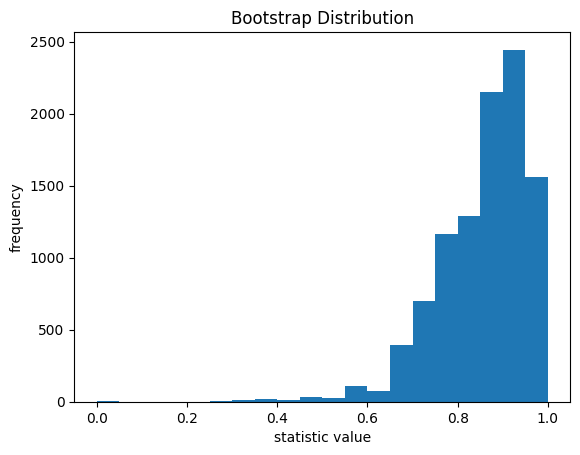

In [9]:
## We need confidence intervals for cohens kappa
# Probably the most reliable way is to do this with bootstraping

df_tmp = pd.DataFrame([{"c1": 'BL1_Liver morphology (0=normal, 1=abnormal)', 
               "c2": 'BL2_Liver morphology'}])
df_tmp = pd.concat([df_pairs_non_metric, df_tmp]).reset_index()

idx = 0
idx = 11
c1, c2 = df_tmp.loc[idx, "c1"], df_tmp.loc[idx, "c2"]
print(f"{c1=}   {c2=}")
data = df[[c1, c2]].dropna().reset_index(drop=True).rename(columns={c1: "y1", c2: "y2"})
data

# kappa = sklearn.metrics.cohen_kappa_score(data["y1"], data["y2"])
y1 = data["y1"].to_numpy()
y2 = data["y2"].to_numpy()


data_bootstrap = (y1, y2)
labels=np.array(list(set(y1) | set(y2)))
print("labels = ", labels)
estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels)
res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
print("Esitmator: ", estimator(y1, y2))
print(res.confidence_interval)

fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=20)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [10]:


# All variables which need some extra preprocessing: 
display(df_pairs_non_metric_2)

,c1,c2
0,"BL1_FNH-like lesions (0=no, 1=yes)",BL2_FNH-like lesions
1,"BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mura...",BL2_Splanchnic thrombosis
2,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities
3,"BL1_Location (1=PV, 2=SMV, 3=SV)",BL2_Location


In [11]:
i=0
c1, c2 = df_pairs_non_metric_2.iloc[i, :].to_numpy()
print("c1", c1, "\nc2", c2)
print("Unique values: ", set(list(df[c1]) + list(df[c2])))

y = df[c1]
y1 = np.select([y==0, y==1, y=="only pv phase"], [0,1,2], default=np.nan)
y = df[c2]
y2 = np.select([y==0, y==1, y=="only pv phase"], [0,1,2], default=np.nan)



y1 = data["y1"].to_numpy()
y2 = data["y2"].to_numpy()
data_bootstrap = (y1, y2)
labels=np.array(list(set(y1) | set(y2)))
print("labels = ", labels)
estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels, weights=None)
kappa = estimator(y1, y2)
res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
CI95 = [np.round(res.confidence_interval.low, 3), np.round(min(res.confidence_interval.high, 1), 3)]

r = {"c1": c1, 
     "c2": c2, 
     "cohen kappa (not weighted)": kappa, 
     "notes": "The entry 'only pv phase' was treated as a seperate category. ", 
     "cohen kappa (not weighted) -- bootstrap CI95": CI95
     }

agreement_results_non_metric_other = pd.DataFrame([r])
agreement_results_non_metric_other


c1 BL1_FNH-like lesions (0=no, 1=yes) 
c2 BL2_FNH-like lesions 
Unique values:  {0, 1, 'only pv phase'}
labels =  [0 1]


,c1,c2,cohen kappa (not weighted),notes,cohen kappa (not weighted) -- bootstrap CI95
0,"BL1_FNH-like lesions (0=no, 1=yes)",BL2_FNH-like lesions,0.868775,The entry 'only pv phase' was treated as a sep...,"[0.738, 1]"


In [12]:
i=1
c1, c2 = df_pairs_non_metric_2.iloc[i, :].to_numpy()
print("c1", c1, "\nc2", c2)
print("Unique values: ", set(list(df[c1]) + list(df[c2])))

y1 = df[c1]
y2 = df[c2]

# check that non nulls are in the data
assert (y1.isnull().any(), y2.isnull().any()) == (False, False) 

i = 1
y1_1 = y1.apply(lambda x: str(i) in str(x))
y2_1 = y2.apply(lambda x: str(i) in str(x))
y1 = y1_1.to_numpy()
y2 = y2_1.to_numpy()
data_bootstrap = (y1, y2)
labels=np.array(list(set(y1) | set(y2)))
print("labels = ", labels)
estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels, weights=None)
res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
CI95 = [np.round(res.confidence_interval.low, 3), np.round(min(res.confidence_interval.high, 1), 3)]
CI95_1 = CI95

i = 2
y1 = df[c1]
y2 = df[c2]
y1_2 = y1.apply(lambda x: str(i) in str(x))
y2_2 = y2.apply(lambda x: str(i) in str(x))
y1 = y1_2.to_numpy()
y2 = y2_2.to_numpy()
data_bootstrap = (y1, y2)
labels=np.array(list(set(y1) | set(y2)))
print("labels = ", labels)
estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels, weights=None)
res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
CI95 = [np.round(res.confidence_interval.low, 3), np.round(min(res.confidence_interval.high, 1), 3)]
CI95_2 = CI95

rows = []
rows.append({"c1": c1, "c2": c2, 
            "cohen kappa (not weighted)": my_cohen_kappa_score(y1_1, y2_1), 
            "notes": "Compare '1' vs 'not 1'", 
            "cohen kappa (not weighted) -- bootstrap CI95": CI95_1
            })

rows.append({"c1": c1, "c2": c2, 
            "cohen kappa (not weighted)": my_cohen_kappa_score(y1_2, y2_2), 
            "notes": "Compare '2' vs 'not 2'",
            "cohen kappa (not weighted) -- bootstrap CI95": CI95_2 
            })


agreement_results_non_metric_other_ = pd.DataFrame(rows)
agreement_results_non_metric_other = pd.concat([agreement_results_non_metric_other, agreement_results_non_metric_other_]).reset_index().drop(columns=["index"])
print(rows)

c1 BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mural calcifications) 
c2 BL2_Splanchnic thrombosis
Unique values:  {0, 1, 2, 1.2, '1 ; 2'}
labels =  [False  True]
labels =  [False  True]
[{'c1': 'BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mural calcifications)', 'c2': 'BL2_Splanchnic thrombosis', 'cohen kappa (not weighted)': 0.9495440729580178, 'notes': "Compare '1' vs 'not 1'", 'cohen kappa (not weighted) -- bootstrap CI95': [0.899, 1]}, {'c1': 'BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mural calcifications)', 'c2': 'BL2_Splanchnic thrombosis', 'cohen kappa (not weighted)': 1.0, 'notes': "Compare '2' vs 'not 2'", 'cohen kappa (not weighted) -- bootstrap CI95': [1.0, 1.0]}]


In [13]:


i=2
c1, c2 = df_pairs_non_metric_2.iloc[i, :].to_numpy()
print("c1", c1, "\nc2", c2)
print("Unique values: ", set(list(df[c1]) + list(df[c2])))

y1 = df[c1]
y2 = df[c2]


[sum(y1.apply(lambda x: str(j) in str(x))) for j in range(5)], [sum(y1.apply(lambda x: str(j) in str(x))) for j in range(5)]



c1 BL1_Intrahepatic portal abnormalities (0=none, 1=reduced caliber, 2=thrombosis, 3=lack of visibility, 4=intrahepatic collaterals) 
c2 BL2_Intrahepatic portal abnormalities
Unique values:  {0, 1, 2, 3, 4, 2.3, 3.4, 1.4, 2.4, 1.3, '1,2,4 ', '1 ; 2 ; 4 ', '2,3,4', '1 ; 3', '1 ; 4', '1 ; 2 ; 4', '2 ; 4', '1,2,4', '1 ; 2'}


([131, 21, 9, 2, 13], [131, 21, 9, 2, 13])

In [14]:


i=2
c1, c2 = df_pairs_non_metric_2.iloc[i, :].to_numpy()
print("c1", c1, "\nc2", c2)
print("Unique values: ", set(list(df[c1]) + list(df[c2])))

y1 = df[c1]
y2 = df[c2]



# check that non nulls are in the data
assert (y1.isnull().any(), y2.isnull().any()) == (False, False) 

rows = []
for j in range(1, 5):
    y1 = df[c1]
    y2 = df[c2]
    y1_ = y1.apply(lambda x: str(j) in str(x))
    y2_ = y2.apply(lambda x: str(j) in str(x))
    
    y1 = y1_.to_numpy()
    y2 = y2_.to_numpy()
    data_bootstrap = (y1, y2)
    labels=np.array(list(set(y1) | set(y2)))
    print("labels = ", labels)
    estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels, weights=None)
    kappa = estimator(y1, y2)
    res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
    CI95 = [np.round(res.confidence_interval.low, 3), np.round(min(res.confidence_interval.high, 1), 3)]
    rows.append({"c1": c1, "c2": c2, 
                "cohen kappa (not weighted)": kappa, 
                "notes": f"Compare '{j}' vs 'not {j}'",
                "cohen kappa (not weighted) -- bootstrap CI95": CI95
                })


agreement_results_non_metric_other_ = pd.DataFrame(rows)
agreement_results_non_metric_other = pd.concat([agreement_results_non_metric_other, agreement_results_non_metric_other_]).reset_index().drop(columns=["index"])

agreement_results_non_metric_other

c1 BL1_Intrahepatic portal abnormalities (0=none, 1=reduced caliber, 2=thrombosis, 3=lack of visibility, 4=intrahepatic collaterals) 
c2 BL2_Intrahepatic portal abnormalities
Unique values:  {0, 1, 2, 3, 4, 2.3, 3.4, 1.4, 2.4, 1.3, '1,2,4 ', '1 ; 2 ; 4 ', '2,3,4', '1 ; 3', '1 ; 4', '1 ; 2 ; 4', '2 ; 4', '1,2,4', '1 ; 2'}
labels =  [False  True]
labels =  [False  True]
labels =  [False  True]
labels =  [False  True]


,c1,c2,cohen kappa (not weighted),notes,cohen kappa (not weighted) -- bootstrap CI95
0,"BL1_FNH-like lesions (0=no, 1=yes)",BL2_FNH-like lesions,0.868775,The entry 'only pv phase' was treated as a sep...,"[0.738, 1]"
1,"BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mura...",BL2_Splanchnic thrombosis,0.949544,Compare '1' vs 'not 1',"[0.899, 1]"
2,"BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mura...",BL2_Splanchnic thrombosis,1.000000,Compare '2' vs 'not 2',"[1.0, 1.0]"
3,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.866431,Compare '1' vs 'not 1',"[1.0, 1.0]"
4,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,1.000000,Compare '2' vs 'not 2',"[1.0, 1.0]"
5,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.490798,Compare '3' vs 'not 3',"[1.0, 1.0]"
6,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.922029,Compare '4' vs 'not 4',"[1.0, 1.0]"


In [15]:
i=3
c1, c2 = df_pairs_non_metric_2.iloc[i, :].to_numpy()
print("c1", c1, "\nc2", c2)
print("Unique values: ", set(list(df[c1]) + list(df[c2])))

y1 = df[c1]
y2 = df[c2]
assert (y1.isnull().any(), y2.isnull().any()) == (False, False) 

y1_ = y1!=0
y2_ = y2!=0

y1 = y1_.to_numpy()
y2 = y2_.to_numpy()
data_bootstrap = (y1, y2)
labels=np.array(list(set(y1) | set(y2)))
print("labels = ", labels)
estimator = lambda y1, y2: my_cohen_kappa_score(y1, y2, labels=labels, weights=None)
kappa = estimator(y1, y2)
res =  scipy.stats.bootstrap(data_bootstrap, estimator, paired=True, method='basic', random_state=rng, confidence_level=0.95)
CI95 = [np.round(res.confidence_interval.low, 3), np.round(min(res.confidence_interval.high, 1), 3)]

{"c1": c1, "c2": c2, 
                "cohen kappa (not weighted)": kappa, 
                "notes": f"Compare as binary category (any type) vs. none;   any type (PV, SV, ...) -> 1; 0 -> 0",
                "cohen kappa (not weighted) -- bootstrap CI95": CI95
                }

rows
agreement_results_non_metric_other_ = pd.DataFrame(rows)
agreement_results_non_metric_other = pd.concat([agreement_results_non_metric_other, agreement_results_non_metric_other_]).reset_index().drop(columns=["index"])

agreement_results_non_metric_other

c1 BL1_Location (1=PV, 2=SMV, 3=SV) 
c2 BL2_Location
Unique values:  {0, 'PV (intrahep left)', 'PV (intrahep)', 'SMV', 'PV (main PV et right portal vein)', 'PV (main PV)', 'PV (main)', 'PV (extrahep.)', 'PV (main PV), SMV, SV', 'PV (left+right intrahep)', 'SV, SMV', 'PV (left main)', 'PV (left portal vein main+intrahep)', 'SV', 'PV (main+right main+right intrahep PV)', 'PV (intra- and extrahep.), SMV', 'PV (right portal vein)', 'PV (intra- and extrahep.)', 'PV (intra- and extrahep+main left.)', 'SMV,SV', 'PV (main right+intrahep.)', 'PV (main), SMV', 'SV (cavernoma)', 'PV (left main+intrahep)', 'PV (extrahep.), SMV', 'SV ', 'PV (main PV), SMV', 'PV (intra- and extrahep+main left)', 'PV (left portal vein main)', 'PV (main PV+main left),  SMV, SV', 'PV (main PV and intrahep)', 'SMV, SV', 'PV (intrahep obliteration)', 'PV (intra- and extrahep), SMV'}
labels =  [False  True]


,c1,c2,cohen kappa (not weighted),notes,cohen kappa (not weighted) -- bootstrap CI95
0,"BL1_FNH-like lesions (0=no, 1=yes)",BL2_FNH-like lesions,0.868775,The entry 'only pv phase' was treated as a sep...,"[0.738, 1]"
1,"BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mura...",BL2_Splanchnic thrombosis,0.949544,Compare '1' vs 'not 1',"[0.899, 1]"
2,"BL1 Splanchnic thrombosis (0=no, 1=yes, 2=mura...",BL2_Splanchnic thrombosis,1.000000,Compare '2' vs 'not 2',"[1.0, 1.0]"
3,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.866431,Compare '1' vs 'not 1',"[1.0, 1.0]"
4,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,1.000000,Compare '2' vs 'not 2',"[1.0, 1.0]"
5,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.490798,Compare '3' vs 'not 3',"[1.0, 1.0]"
6,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.922029,Compare '4' vs 'not 4',"[1.0, 1.0]"
7,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.866431,Compare '1' vs 'not 1',"[1.0, 1.0]"
8,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,1.000000,Compare '2' vs 'not 2',"[1.0, 1.0]"
9,"BL1_Intrahepatic portal abnormalities (0=none,...",BL2_Intrahepatic portal abnormalities,0.490798,Compare '3' vs 'not 3',"[1.0, 1.0]"


In [16]:
# save data
df_results_all = pd.concat([agreement_results_metric, agreement_results_non_metric, agreement_results_non_metric_other]).reset_index().drop(columns=["index"])
df_results_all = df_results_all[['c1', 'c2', 'notes', 'cohen kappa (not weighted)', 'cohen kappa (linear weighted)', 'ICC2:  ICC', 'ICC2:  CI95%', 
                "cohen kappa (not weighted) -- bootstrap CI95", 
                "cohen kappa (linear weighted) -- bootstrap CI95"]]

df_results_all.to_excel(data_path_output / "reader_comparison_statistics.xlsx", index=False)
print("Saved results to ", data_path_output / "reader_comparison_statistics.xlsx")

Saved results to  /home/cwatzenboeck/data/psvd/output_coxph/reader_comparison_statistics.xlsx


In [17]:
df_results_all

,c1,c2,notes,cohen kappa (not weighted),cohen kappa (linear weighted),ICC2: ICC,ICC2: CI95%,cohen kappa (not weighted) -- bootstrap CI95,cohen kappa (linear weighted) -- bootstrap CI95
0,BL1_Spleen size (cm),BL2_Spleen size (cm),NaN,NaN,NaN,0.987582,"[0.98, 0.99]",NaN,NaN
1,BL1_TPMT,BL2_TPMT,NaN,NaN,NaN,0.907136,"[0.81, 0.95]",NaN,NaN
2,"BL1_Ascites (0=none, 1=little, 2=moderate, 3=s...",BL2_Ascites,NaN,NaN,0.958706,NaN,NaN,NaN,"[0.888, 0.998]"
3,"BL1_PV overall extent (no PVT=0, <50%=1, ≥50%=2)","BL2_PV overall extent (no PVT=0, <50%=1, ≥50%=2)",NaN,NaN,0.951224,NaN,NaN,NaN,"[0.895, 1]"
4,"BL1_SPSS (0=no, 1=yes)",BL2_SPSS,NaN,0.963021,NaN,NaN,NaN,"[0.926, 1]",NaN
5,"BL1_L-SPSS (0=no, 1=yes)",BL2_L-SPSS,NaN,0.984650,NaN,NaN,NaN,"[0.969, 1]",NaN
6,BL1_intrahep./LPV/RPV,BL2_intrahep./LPV/RPV,NaN,0.959689,NaN,NaN,NaN,"[0.919, 1]",NaN
7,BL1_SMV/SV,BL2_SMV/SV,NaN,0.953292,NaN,NaN,NaN,"[0.907, 1]",NaN
8,"BL1_segment 1 (0=normal, 1=atrophy, 2=hypertro...",BL2_segment 1,NaN,0.901288,NaN,NaN,NaN,"[0.803, 1]",NaN
9,"BL1_segment IV (0=normal, 1=atrophy, 2=hypertr...",BL2_segment IV,NaN,0.894456,NaN,NaN,NaN,"[0.835, 0.963]",NaN
